# Data

In [1]:
import pandas as pd

data = pd.read_csv('data.csv', encoding='utf-16')
data

,artist,title,text
0,25/17,Подорожник,"Через поле, через лес, В небе – солнце, в луже..."
1,25/17,Звезда,"Почему не спишь? Я за нас двоих небеса молю, П..."
2,25/17,Комната,Белый шум на мониторе пыльного окна Расскажет ...
3,25/17,Живым,"Кстати, скажите, А вы не страдаете ли чем-нибу..."
4,Любэ,Конь,"Выйду ночью в поле с конем, Ночкой темной тихо..."
5,Вера Брежнева,Хорошие новости,"Мне не нужны золотые берега, милый Мне не нужн..."
6,кис-кис,Молчи,"Молчи, когда бухой сосед на свою тёлку кричит ..."
7,Каста,Фотка,"Хорошо сидим, надо сфотаться Кто у нас тут спе..."
8,Каста,Прошел через,"Хоть ты малой еще, но это твой финальный пункт..."
9,кис-кис,Весна,Зачем снова за окном зацвела сирень? С новым п...


In [2]:
import os
os.chdir("../../")

In [3]:
import Pipeline.Preprocessing.YouTubeMetaExtraction as yt
from datetime import datetime

In [4]:
def to_secs(time):
    total_seconds = time.second + time.minute * 60 + time.hour * 3600
    return total_seconds

In [5]:
def get_info(path_to_meta):
    link = ''
    start_sec = 0
    end_sec = 0
    with open(path_to_meta) as meta:
            for line in meta:
                
                if line.startswith("http"):
                    link = line.rstrip("\n")
                    continue
                    
                split = line.split(",")
                start = split[0]
                end = split[1]
                label = split[2]
                genre = split[3] if len(split) > 3 else 'none'
                
                if (label == "song\n" or label == "song"):
                    
                    start = datetime.strptime(start, '%H:%M:%S')
                    end = datetime.strptime(end, '%H:%M:%S')
                    start_sec = to_secs(start)
                    end_sec = to_secs(end)
                    continue
                    
    data = {}       
    
    video = yt.YouTubeMetaExtraction(link)
    
    captions = video.get_captions_type_list()
    
    if len(captions) > 0:
        lang_code = captions[0].code
        data['text'] = video.get_text(start_sec, end_sec, lang_code)
    else:
        data['text'] = None
    
    data.update(video.get_specialized_information())
    
    return data       

# Methods

In [6]:
import difflib
import Levenshtein
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

from flair.data import Sentence
from flair.embeddings import WordEmbeddings
glove_embedding = WordEmbeddings('ru')
from flair.embeddings import DocumentPoolEmbeddings
document_embeddings  =  DocumentPoolEmbeddings ([ glove_embedding])

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
from pymystem3 import Mystem

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def del_stopwords_text(text):
    
    tokens = text.split(" ")
    
    tokens = [token for token in tokens if token not in russian_stopwords\
                and token != " " \
                and token.strip() not in punctuation]
    
    text = " ".join(tokens)

    return text

In [8]:
def lemmatize_text(text):
    tokens = mystem.lemmatize(text.lower())
    text = " ".join(tokens)
    return text

In [9]:
def similarity(s1, s2):
    
    normalized1 = del_stopwords_text(s1)
    normalized2 = del_stopwords_text(s2)
    
    matcher = difflib.SequenceMatcher(None, normalized1, normalized2)
    return matcher.ratio()

In [10]:
def part_embedding(sentence, parts):
    new = []
    num = len(sentence) // parts
    
    for i in range(parts-1):
        ptr = sentence[num*i:num*(i+1)].T
        for line in ptr:
            new.append(line.mean())
            
    ptr = sentence[num*(parts-1) : ].T
    for line in ptr:
            new.append(line.mean())
    
    return new

In [11]:
def diff_parts(t1, t2, parts=4, preprocess=True):
    
    if preprocess:
        t1 = del_stopwords_text(t1)
        t2 = del_stopwords_text(t2)
    
    s1 = Sentence(t1)
    s2 = Sentence(t2)
    
    glove_embedding.embed(s1)
    glove_embedding.embed(s2)
    
    emb1 = []
    emb2 = []
    
    for word in s1:
        emb1.append(np.array(word.embedding))
    for word in s2:
        emb2.append(np.array(word.embedding))
        
    emb1 = np.array(emb1)
    emb2 = np.array(emb2)
    
    new1 = part_embedding(emb1, parts)
    new2 = part_embedding(emb2, parts)
    
    return mse(new2, new1)

In [12]:
def diff_text(t1, t2, preprocess=True):
    
    if preprocess:
        t1 = del_stopwords_text(t1)
        t2 = del_stopwords_text(t2)
    
    s1 = Sentence(t1)
    s2 = Sentence(t2)
    
    document_embeddings.embed(s1)
    document_embeddings.embed(s2)
    
    return mse(s2.embedding, s1.embedding)

# Pipeline

In [13]:
path = 'Notebooks/meta_text/songs/'
format = '.txt'

list_of_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(format):
            list_of_paths.append(os.path.join(root, file))

In [14]:
meta_inf = []
for file in list_of_paths:
    meta_inf.append(get_info(file))

E:\jupiter\song-cutter\Pipeline\Preprocessing\YouTubeMetaExtraction.py:85: DeprecationWarning: Call to deprecated function all (This object can be treated as a dictionary).
  return self.__video.captions.all()
E:\jupiter\song-cutter\Pipeline\Preprocessing\YouTubeMetaExtraction.py:85: DeprecationWarning: Call to deprecated function all (This object can be treated as a dictionary).
  return self.__video.captions.all()
E:\jupiter\song-cutter\Pipeline\Preprocessing\YouTubeMetaExtraction.py:75: DeprecationWarning: Call to deprecated function get_by_language_code (This object can be treated as a dictionary, i.e. captions['en']).
  cap = self.__video.captions.get_by_language_code(language_code)
E:\jupiter\song-cutter\Pipeline\Preprocessing\YouTubeMetaExtraction.py:85: DeprecationWarning: Call to deprecated function all (This object can be treated as a dictionary).
  return self.__video.captions.all()
E:\jupiter\song-cutter\Pipeline\Preprocessing\YouTubeMetaExtraction.py:85: DeprecationWarning

In [15]:
data['text'] = [lemmatize_text(data.text[i]) for i in range(len(data['text']))]

In [16]:
for i in range(len(meta_inf)):
    meta_inf[i]['text'] = lemmatize_text(meta_inf[i]['text'])

## Difflib Similarity

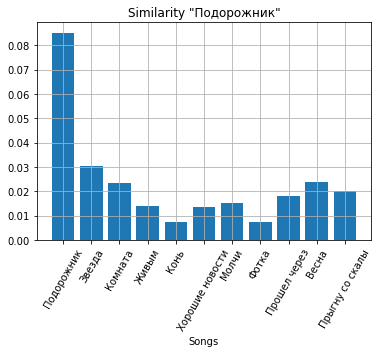

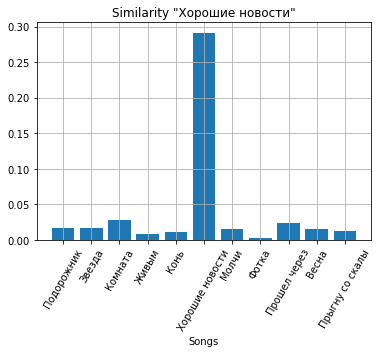

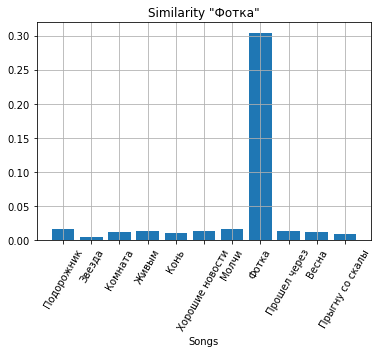

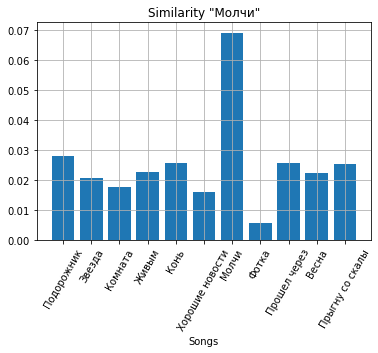

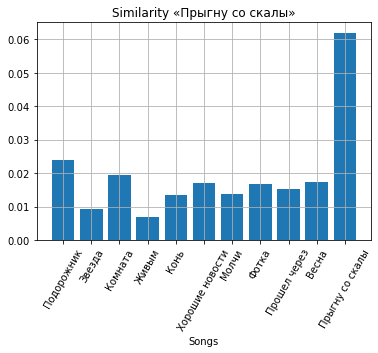

In [17]:
for j in range(len(meta_inf)):
    res = []
    for i in range(len(data['text'])):
        res.append(similarity(meta_inf[j]['text'], data['text'][i]))

    plt.bar( [i for i in range(len(data['text']))], np.array(res))
    plt.xlabel('Songs')
    plt.xticks([i for i in range(len(data['title']))], data['title'], rotation=60)
    plt.ylabel('')
    plt.title('Similarity ' + str(meta_inf[j]['song_title']))
    plt.grid()
    plt.show()

## Levenshtein ratio

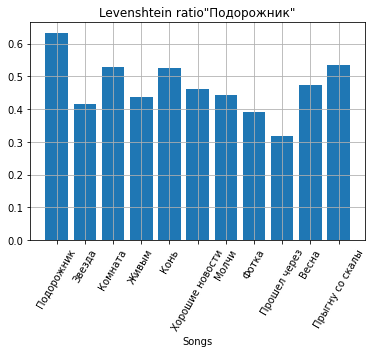

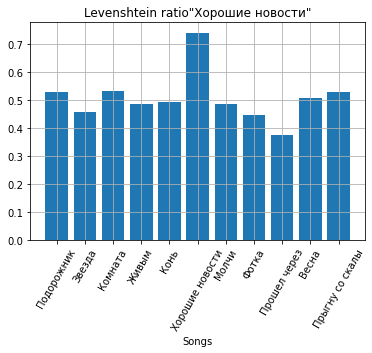

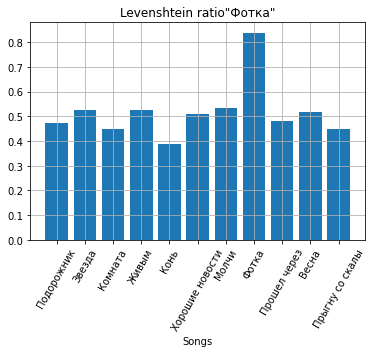

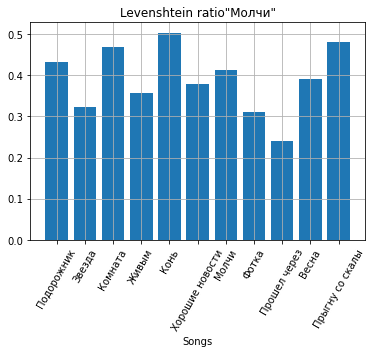

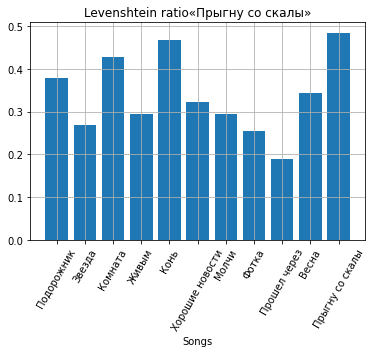

In [18]:
for j in range(len(meta_inf)):
    res = []
    for i in range(len(data['text'])):
        res.append(Levenshtein.ratio(meta_inf[j]['text'].lower(), data['text'][i].lower()))

    plt.bar( [i for i in range(len(data['text']))], np.array(res))
    plt.xlabel('Songs')
    plt.xticks([i for i in range(len(data['title']))], data['title'], rotation=60)
    plt.ylabel('')
    plt.title('Levenshtein ratio' + str(meta_inf[j]['song_title']))
    plt.grid()
    plt.show()

## Flair parts

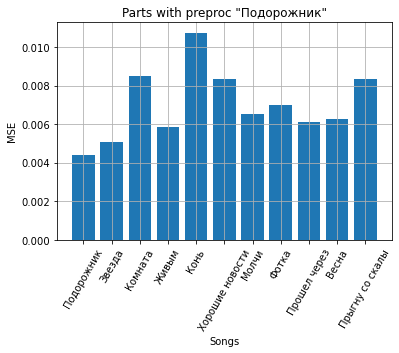

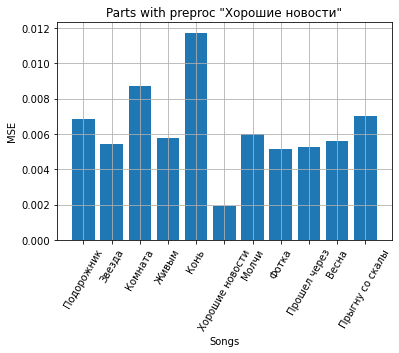

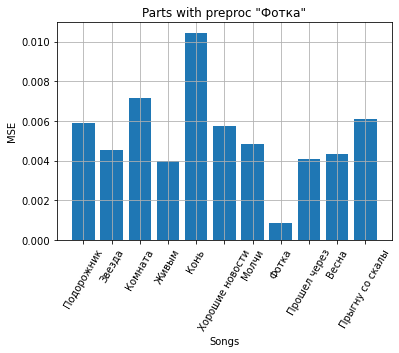

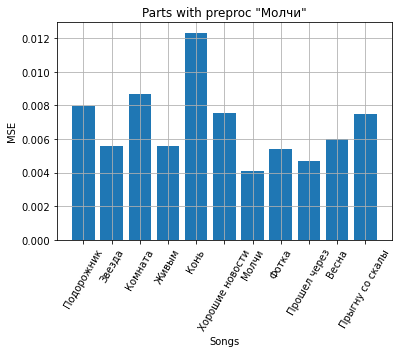

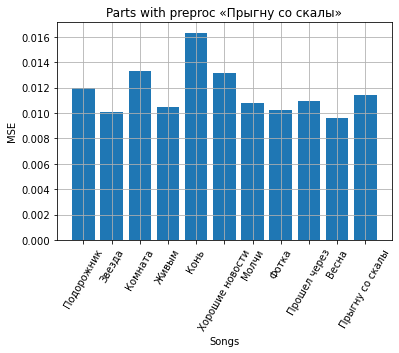

In [19]:
for j in range(len(meta_inf)):
    res = []
    for i in range(len(data['text'])):
        res.append(diff_parts(meta_inf[j]['text'], data['text'][i]))

    plt.bar( [i for i in range(len(data['text']))], np.array(res))
    plt.xlabel('Songs')
    plt.xticks([i for i in range(len(data['title']))], data['title'], rotation=60)
    plt.ylabel('MSE')
    plt.title('Parts with preproc ' + str(meta_inf[j]['song_title']))
    plt.grid()
    plt.show()

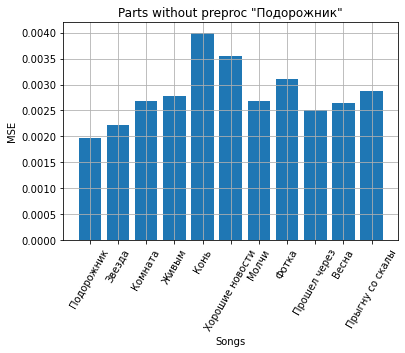

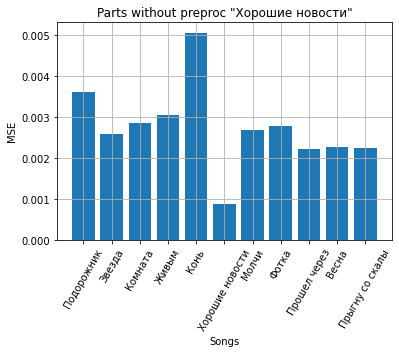

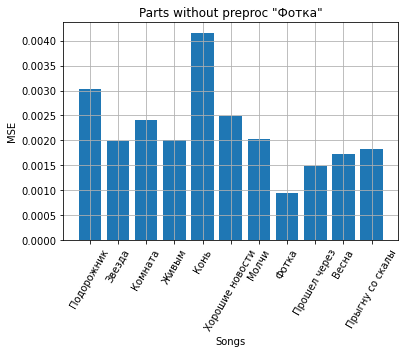

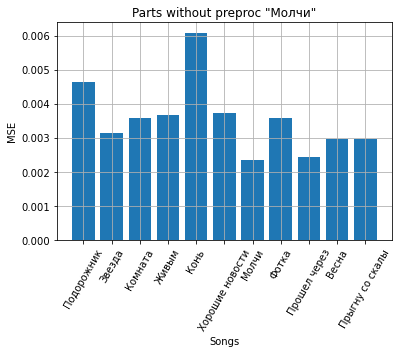

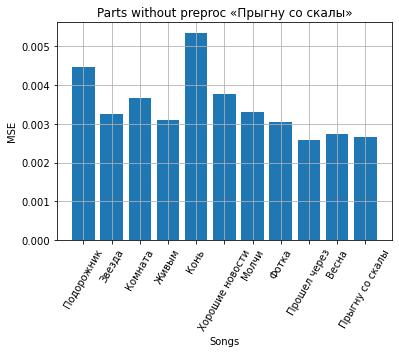

In [20]:
for j in range(len(meta_inf)):
    res = []
    for i in range(len(data['text'])):
        res.append(diff_parts(meta_inf[j]['text'], data['text'][i], preprocess=False))

    plt.bar( [i for i in range(len(data['text']))], np.array(res))
    plt.xlabel('Songs')
    plt.xticks([i for i in range(len(data['title']))], data['title'], rotation=60)
    plt.ylabel('MSE')
    plt.title('Parts without preproc ' + str(meta_inf[j]['song_title']))
    plt.grid()
    plt.show()

## Flair all

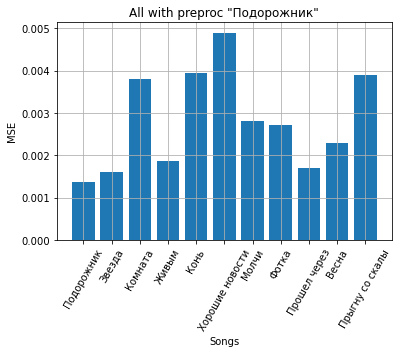

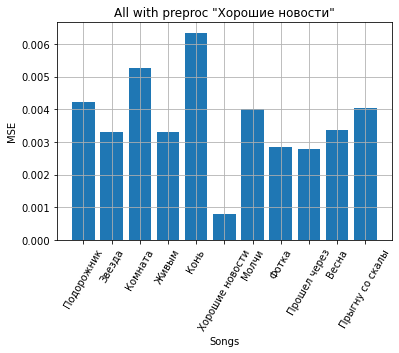

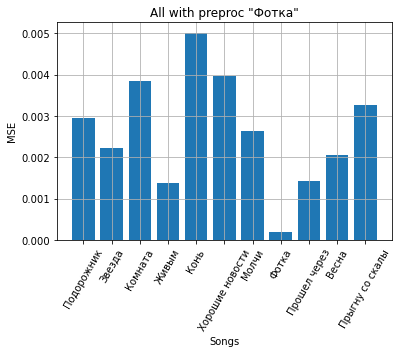

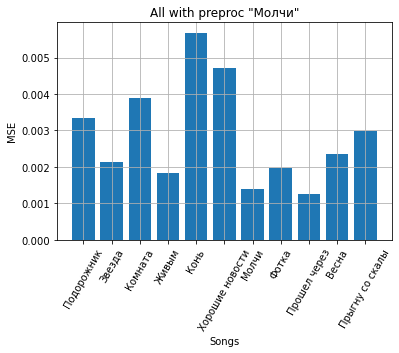

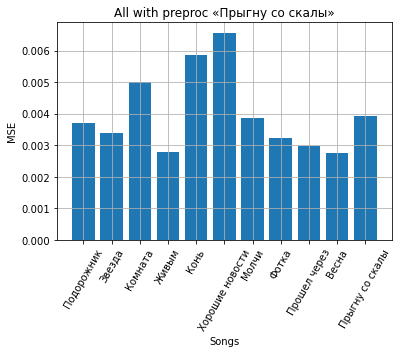

In [21]:
for j in range(len(meta_inf)):
    res = []
    for i in range(len(data['text'])):
        res.append(diff_text(meta_inf[j]['text'], data['text'][i]))

    plt.bar( [i for i in range(len(data['text']))], np.array(res))
    plt.xlabel('Songs')
    plt.xticks([i for i in range(len(data['title']))], data['title'], rotation=60)
    plt.ylabel('MSE')
    plt.title('All with preproc ' + str(meta_inf[j]['song_title']))
    plt.grid()
    plt.show()

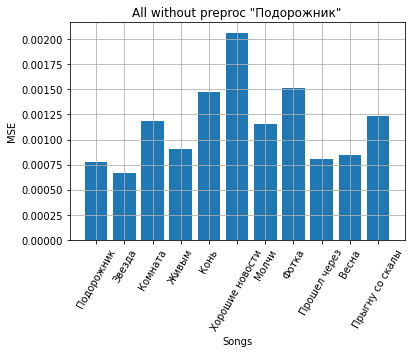

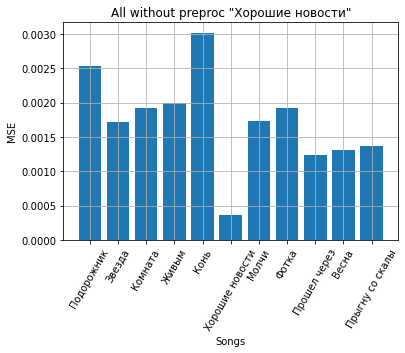

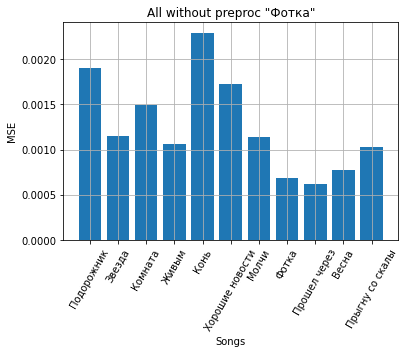

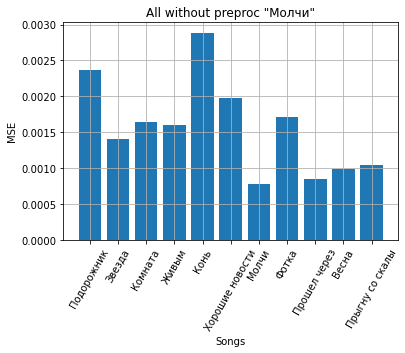

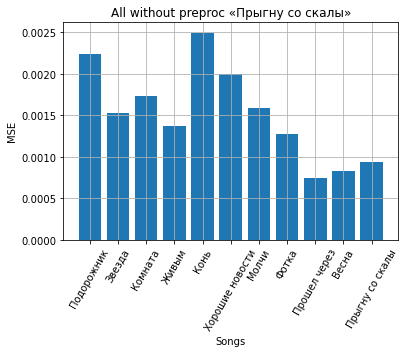

In [22]:
for j in range(len(meta_inf)):
    res = []
    for i in range(len(data['text'])):
        res.append(diff_text(meta_inf[j]['text'], data['text'][i], preprocess=False))

    plt.bar( [i for i in range(len(data['text']))], np.array(res))
    plt.xlabel('Songs')
    plt.xticks([i for i in range(len(data['title']))], data['title'], rotation=60)
    plt.ylabel('MSE')
    plt.title('All without preproc ' + str(meta_inf[j]['song_title']))
    plt.grid()
    plt.show()